#### Imports & Setup

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import ee
import geemap
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime, timedelta
from scipy import stats

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# authenticate & init GEE
ee.Authenticate()
ee.Initialize(project='')

#### Target Data from Weather Stations
Source: [Open Energy Data Initiative (OEDI)](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=sup3ruhi%2F)

In [4]:
def read_show_target_data(file_path):
  '''
  read in target data (weather stations with air temperature)
  '''
  df = pd.read_csv(file_path, delimiter=",")
  print('shape:', df.shape)
  df['time_index_dt'] = pd.to_datetime(df['time_index'])
  display(df.head())

  return df


def get_bounding_box(df):
  '''
  create bounding box based on available weather stations
  '''
  mean_lon, mean_lat = df.longitude.mean(), df.latitude.mean()
  min_lon, min_lat = df[['longitude', 'latitude']].values.min(axis=0)
  max_lon, max_lat = df[['longitude', 'latitude']].values.max(axis=0)
  bounding_box = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
  print('min lon,lat:', min_lon, min_lat)
  print('max lon, lat:', max_lon, max_lat)
  return bounding_box

def get_landsat_tiles(landsat_path, bounding_box, start_date, end_date, overlap):
  '''
  fetch tiles from path via GEE and filter based on overlap with bounding box
  '''
  landsat = (ee.ImageCollection(landsat_path).filterBounds(bounding_box).filterDate(start_date, end_date))
  bounding_box_area = bounding_box.area()

  def compute_overlap(image):
      overlap = image.geometry().intersection(bounding_box).area().divide(bounding_box_area)
      return image.set('overlap_fraction', overlap)

  landsat_filt = landsat.map(compute_overlap).filter(ee.Filter.gte('overlap_fraction', overlap))
  print('number of days:', landsat_filt.size().getInfo())
  return landsat, landsat_filt

In [5]:
madis_la_2016 = read_show_target_data("/content/drive/madis_los_angeles_2016_clean_filtered.csv")

shape: (2583530, 9)


,time_index,latitude,longitude,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt
0,2016-01-01 00:00:00,34.09472,-118.65667,2016-01-01 00:00:00,12.66668,21.0,2.906611,30.0,34.09472_-118.65667,2016-01-01 00:00:00
1,2016-01-01 01:00:00,34.09472,-118.65667,2016-01-01 00:30:00,11.94445,22.0,1.476455,48.0,34.09472_-118.65667,2016-01-01 01:00:00
2,2016-01-01 02:00:00,34.09472,-118.65667,2016-01-01 01:30:00,10.77776,23.0,1.965178,24.0,34.09472_-118.65667,2016-01-01 02:00:00
3,2016-01-01 03:00:00,34.09472,-118.65667,2016-01-01 02:30:00,9.94445,24.0,2.371589,104.0,34.09472_-118.65667,2016-01-01 03:00:00
4,2016-01-01 04:00:00,34.09472,-118.65667,2016-01-01 03:30:00,9.66668,25.0,1.250100,101.0,34.09472_-118.65667,2016-01-01 04:00:00


In [6]:
bounding_box = get_bounding_box(madis_la_2016)

min lon,lat: -119.37125 33.309795
max lon, lat: -117.40817 35.11383


#### Remotely sensed data with GEE

In [7]:
start_date = '2016-01-01'
end_date = '2016-12-31'

In [8]:
landsat, landsat_filt = get_landsat_tiles("LANDSAT/LC08/C02/T1_L2", bounding_box, start_date, end_date, 0.7)

number of days: 22


#### Sample satellite iamges at points of weather stations

In [10]:
def get_avail_landsat_dates(landsat_filt):
  '''
  get dates at which landsat images are available (use correct timezone!!)
  '''
  avail_dates = landsat_filt.aggregate_array('system:time_start').map(
      lambda d: ee.Date(d).format('YYYY-MM-dd HH:mm:ss', 'America/Los_Angeles')
  ).distinct().getInfo()
  return avail_dates


def filter_target_data_by_landsat_dates(df, avail_dates):
  '''
  filter target data df to only include rows where the date is within a timewindow of 60 minutes of the landsat image observation time
  '''
  filter_arr = []
  for datet in avail_dates:
    filter_arr.append(df[
      (df['time_index_dt'] >= pd.to_datetime(datet) - pd.Timedelta(minutes=60)) &
      (df['time_index_dt'] <= pd.to_datetime(datet) + pd.Timedelta(minutes=60))
    ])

  filter_df = pd.concat(filter_arr)
  filter_df = filter_df.iloc[(filter_df['time_index_dt'] - pd.to_datetime('2016-06-22 18:30:00')).abs().argsort()]
  # filter to only have unique stations
  filter_df['date'] = filter_df['time_index_dt'].dt.date
  filter_df = filter_df.drop_duplicates(subset=['sid', 'date'])
  return filter_df

In [11]:
# get dates at which those tiles are taken
avail_dates = get_avail_landsat_dates(landsat_filt)
print(avail_dates)

['2016-01-14 10:28:25', '2016-01-30 10:28:23', '2016-02-15 10:28:15', '2016-03-02 10:28:13', '2016-03-18 11:28:08', '2016-04-03 11:27:58', '2016-04-19 11:27:53', '2016-05-05 11:27:56', '2016-05-21 11:27:56', '2016-06-06 11:28:00', '2016-06-22 11:28:05', '2016-07-08 11:28:14', '2016-07-24 11:28:19', '2016-08-09 11:28:21', '2016-08-25 11:28:28', '2016-09-10 11:28:33', '2016-09-26 11:28:33', '2016-10-12 11:28:39', '2016-10-28 11:28:41', '2016-11-13 10:28:40', '2016-11-29 10:28:40', '2016-12-15 10:28:36']


In [12]:
# filter target data based on selected dates, +- an hour
filter_2016 = filter_target_data_by_landsat_dates(madis_la_2016, avail_dates)
filter_2016.head()

,time_index,latitude,longitude,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt,date
1312605,2016-06-22 12:00:00,34.24316,-118.59225,2016-06-22 11:30:23,20.55557,63.0,0.00000,354.0,34.24316_-118.59225,2016-06-22 12:00:00,2016-06-22
1499234,2016-06-22 12:00:00,34.28950,-118.74383,2016-06-22 11:38:19,17.77776,83.0,0.00000,284.0,34.2895_-118.74383,2016-06-22 12:00:00,2016-06-22
1490594,2016-06-22 12:00:00,34.45763,-118.38878,2016-06-22 11:36:02,16.66668,73.0,0.00000,65.0,34.45763_-118.38878,2016-06-22 12:00:00,2016-06-22
1481907,2016-06-22 12:00:00,34.12833,-118.32833,2016-06-22 11:43:10,16.66668,90.0,0.44704,271.0,34.12833_-118.32833,2016-06-22 12:00:00,2016-06-22
1473249,2016-06-22 12:00:00,34.03635,-118.82787,2016-06-22 11:31:30,15.00000,96.0,0.00000,118.0,34.03635_-118.82787,2016-06-22 12:00:00,2016-06-22


In [13]:
# show number of available target data points per date
filter_2016.groupby(['time_index_dt']).sid.count()

,sid
time_index_dt,
2016-01-14 10:00:00,3
2016-01-14 11:00:00,313
2016-01-30 10:00:00,9
2016-01-30 11:00:00,308
2016-02-15 10:00:00,7
2016-02-15 11:00:00,310
2016-03-02 10:00:00,8
2016-03-02 11:00:00,302
2016-03-18 11:00:00,6


In [14]:
def create_target_feature_collection(df):
  '''
  create GEE feature collection from target data
  '''
  features = []
  for _, row in df.iterrows():
      point = ee.Geometry.Point([row['longitude'], row['latitude']])
      feature = ee.Feature(point, {"temperature": row["temperature"], "sid": row["sid"], "date": str(row["date"])})
      features.append(feature)

  return ee.FeatureCollection(features)


def extract_bands(landsat):
  '''
  extract, preprocess, and scale landsat bands
  '''
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = landsat.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
  saturation_mask = landsat.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
      factor_list = landsat.toDictionary().select(factor_names).values()
      return ee.Image.constant(factor_list)

  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = landsat.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  landsat = landsat.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)

  red = landsat.select('SR_B4').rename('Red')
  green = landsat.select('SR_B3').rename('Green')
  blue = landsat.select('SR_B2').rename('Blue')
  swir1 = landsat.select('SR_B6').rename('SWIR1')
  swir2 = landsat.select('SR_B7').rename('SWIR2')
  lst = landsat.select('ST_B10').rename('LST').subtract(273.15)

  # compute indices
  ndvi = landsat.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
  ndbi = landsat.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
  nbai = landsat.normalizedDifference(['SR_B7', 'SR_B5']).rename('NBAI')
  mndwi = landsat.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

  band_dict = {
      'NIR': landsat.select('SR_B5'),
      'RED': landsat.select('SR_B4'),
      'BLUE': landsat.select('SR_B2')
  }

  evi = landsat.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', band_dict).rename('EVI')
  savi = landsat.expression('((NIR - RED) / (NIR + RED + 0.5)) * 1.5', band_dict).rename('SAVI')

  return lst.addBands([red, green, blue, swir1, swir2, ndvi, evi, savi, mndwi, nbai, ndbi])


def sample_bands_via_target_location(landsat_filt, df):
  '''
  for the given available date, extract landsat bands and terrain images, and sample point data given target locations
  '''
  # iteratrue thorugh landsat iamges/dates, sample at target locations
  total_arr = []
  for i in range(landsat_filt.size().getInfo()):
      image = ee.Image(landsat_filt.toList(1, i).get(0))
      datet = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

      features = []
      for _, row in df[df.date == datetime.strptime(datet, '%Y-%m-%d').date()].iterrows():
          point = ee.Geometry.Point([row['longitude'], row['latitude']])
          feature = ee.Feature(point, {"temperature": row["temperature"], "sid": row["sid"], "date": str(row["date"])})
          features.append(feature)

      fc_date = ee.FeatureCollection(features)

      # extract bands at this date
      bands_date = extract_bands(image)

      # extra non-temporally dependent
      srtm = ee.Image("USGS/SRTMGL1_003").select("elevation").rename("Elevation")
      elevation = srtm.clip(bounding_box)
      slope = ee.Terrain.slope(srtm).rename("Slope")
      slope = slope.clip(bounding_box)
      # distance to water using ESA WorldCover (water mask = 80)
      water = ee.Image("ESA/WorldCover/v200/2021").select("Map").eq(80).selfMask()
      water_dist = water.fastDistanceTransform().rename("Water_dist")

      bands_date = bands_date.addBands([elevation, slope, water_dist])

      # sample from bands via created feature collection
      extracted = bands_date.sampleRegions(collection=fc_date, scale=30, geometries=True)

      # create input feature df
      input_feat = []
      for feature in extracted.getInfo()['features']:
          properties = feature['properties']
          coordinates = feature['geometry']['coordinates']

          input_feat.append({
              'sid': properties.get('sid'),
              'date': properties.get('date'),
              'longitude': coordinates[0],
              'latitude': coordinates[1],
              'RED': properties.get('Red'),
              'GREEN': properties.get('Green'),
              'BLUE': properties.get('Blue'),
              'SWIR1': properties.get('SWIR1'),
              'SWIR2': properties.get('SWIR2'),
              'NDVI': properties.get('NDVI'),
              'NDBI': properties.get('NDBI'),
              'NBAI': properties.get('NBAI'),
              'MNDWI': properties.get('MNDWI'),
              'EVI': properties.get('EVI'),
              'SAVI': properties.get('SAVI'),
              'LST': properties.get('LST'),
              'Elevation': properties.get('Elevation'),
              'Slope': properties.get('Slope'),
              'Water_dist': properties.get('Water_dist')
          })

      extracted_df = pd.DataFrame(input_feat)
      total_arr.append(extracted_df)

  return total_arr

In [15]:
# array of date-wise dfs
total_arr = sample_bands_via_target_location(landsat_filt, filter_2016)

In [16]:
def merge_imagery_with_target(total_arr, df):
  '''
  merge sampled remotely sensed data at target locations based on date and id to retrieve temperature,
  as well as include day of year encoding as year-based sine/cosine transform
  '''
  extracted_total = pd.concat(total_arr)
  extracted_total = extracted_total.dropna().drop_duplicates()

  extracted_total['date'] = pd.to_datetime(extracted_total['date']).dt.date
  comb_df = pd.merge(df, extracted_total, on=['sid', 'date'], how='left')
  comb_df = comb_df.dropna()
  print('merged df shape:', comb_df.shape)

  # encode day of year
  comb_df['dayofyear'] = comb_df['time_index_dt'].map(lambda x: pd.to_datetime(x).dayofyear)
  comb_df['sin_time'] = np.sin(2*np.pi*comb_df.dayofyear/365)
  comb_df['cos_time'] = np.cos(2*np.pi*comb_df.dayofyear/365)

  return comb_df

In [17]:
comb_2016 = merge_imagery_with_target(total_arr, filter_2016)
comb_2016.head()

merged df shape: (3961, 28)


,time_index,latitude_x,longitude_x,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt,...,MNDWI,EVI,SAVI,LST,Elevation,Slope,Water_dist,dayofyear,sin_time,cos_time
0,2016-06-22 12:00:00,34.24316,-118.59225,2016-06-22 11:30:23,20.55557,63.0,0.00000,354.0,34.24316_-118.59225,2016-06-22 12:00:00,...,-0.120355,0.056271,0.050698,52.448839,282.0,2.166866,12325.0,174,0.145799,-0.989314
1,2016-06-22 12:00:00,34.28950,-118.74383,2016-06-22 11:38:19,17.77776,83.0,0.00000,284.0,34.2895_-118.74383,2016-06-22 12:00:00,...,-0.229389,0.224268,0.217520,48.518116,322.0,0.927410,7913.0,174,0.145799,-0.989314
2,2016-06-22 12:00:00,34.45763,-118.38878,2016-06-22 11:36:02,16.66668,73.0,0.00000,65.0,34.45763_-118.38878,2016-06-22 12:00:00,...,-0.267465,0.144768,0.148238,51.061123,593.0,3.495359,17425.0,174,0.145799,-0.989314
3,2016-06-22 12:00:00,34.12833,-118.32833,2016-06-22 11:43:10,16.66668,90.0,0.44704,271.0,34.12833_-118.32833,2016-06-22 12:00:00,...,-0.418210,0.316100,0.318102,43.603004,270.0,8.289100,157.0,174,0.145799,-0.989314
4,2016-06-22 12:00:00,34.03635,-118.82787,2016-06-22 11:31:30,15.00000,96.0,0.00000,118.0,34.03635_-118.82787,2016-06-22 12:00:00,...,-0.203612,0.185881,0.164342,40.526786,219.0,17.225477,2450.0,174,0.145799,-0.989314


#### Merge with target data

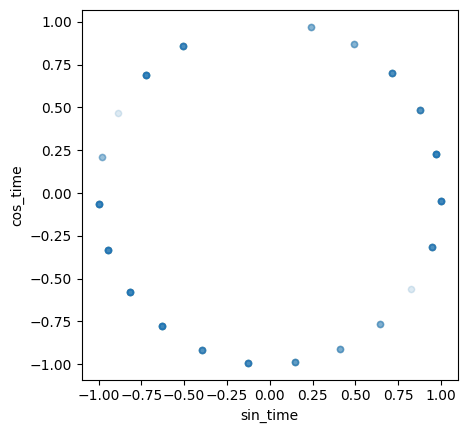

In [23]:
# check frequency throughout the year
comb_2016.sample(500).plot.scatter('sin_time','cos_time', alpha=0.05).set_aspect('equal')

#### Outliers

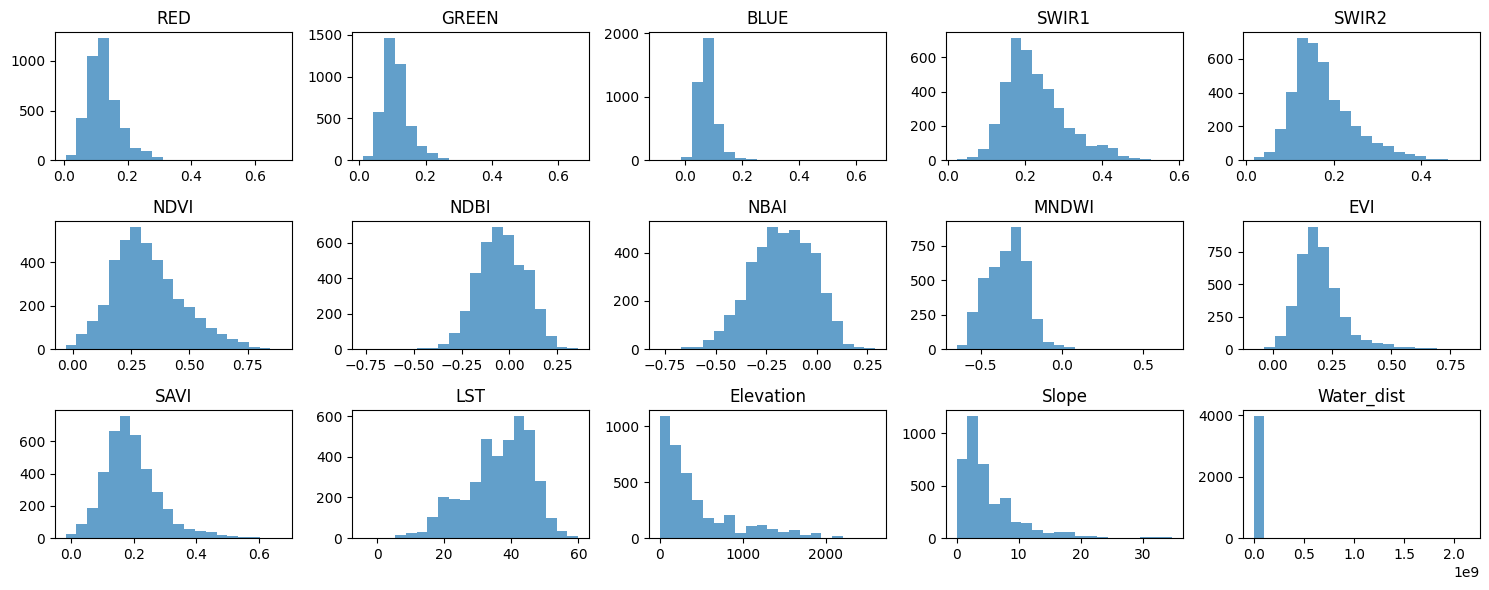

In [19]:
# plot histograms of bands to check distribution
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.flatten()

for i, col in enumerate(['RED', 'GREEN', 'BLUE', 'SWIR1',
       'SWIR2', 'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST', 'Elevation', 'Slope', 'Water_dist']):
    axes[i].hist(comb_2016[col], bins=20, alpha=0.7)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [20]:
# compute z scores and remove rows with a score > 3
z_scores = stats.zscore(comb_2016[['RED', 'GREEN', 'BLUE', 'SWIR1',
       'SWIR2', 'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST', 'Water_dist']])
print('total # outliers:', (abs(z_scores) > 3).sum(axis=0).sum())
(abs(z_scores) > 3).sum(axis=0).sort_values(ascending=False)

total # outliers: 367


,0
EVI,70
SAVI,56
SWIR2,45
BLUE,43
GREEN,38
SWIR1,30
RED,27
MNDWI,14
NDVI,13
NBAI,11


In [21]:
comb_2016 = comb_2016[(abs(z_scores) <= 3).all(axis=1)]
print(comb_2016.shape)

(3782, 31)


In [ ]:
# save to file for later use
comb_2016.to_csv('/content/drive/MyDrive/University/GeoAI_LST/2017_LA_merged_scaled.csv', index=False)

,temperature
temperature,1.000000
LST,0.758702
SWIR1,0.120616
SWIR2,0.107671
Elevation,-0.108861


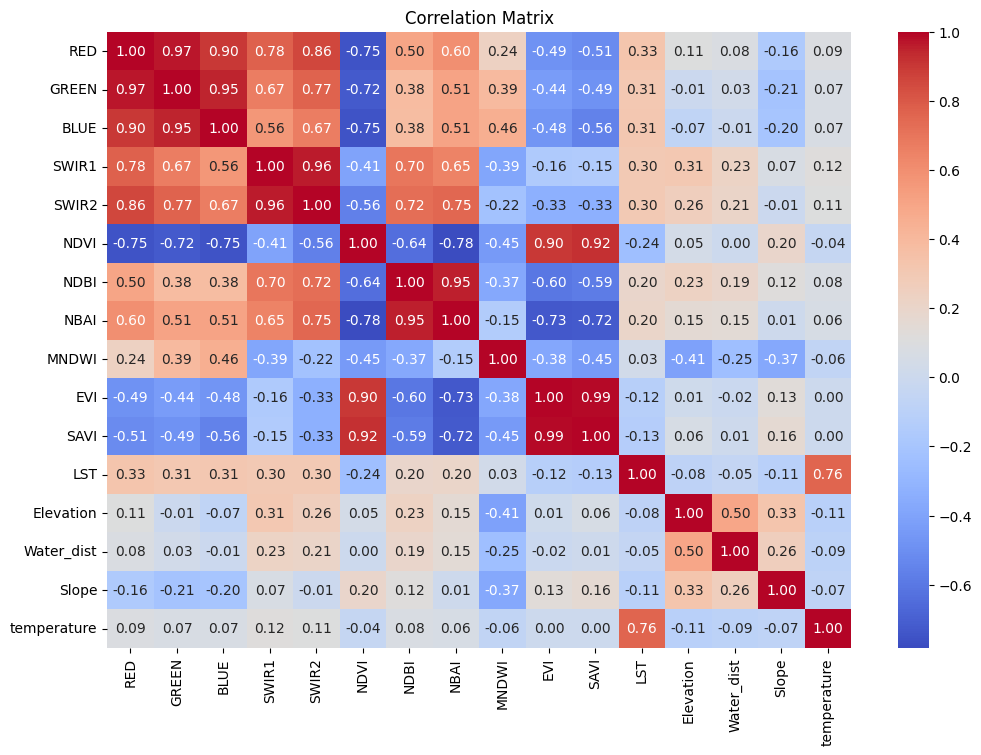

In [ ]:
df_numeric = comb_2016[['RED', 'GREEN', 'BLUE', 'SWIR1', 'SWIR2',
       'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST', 'Elevation',
       'Water_dist', 'Slope', 'temperature']]
corr_matrix = df_numeric.select_dtypes(include='number').corr()

# variables where correlation is bigger than 0.1
display(pd.DataFrame(corr_matrix[abs(corr_matrix) > 0.1]['temperature'].dropna().sort_values(ascending=False)))

# create heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()